<a href="https://colab.research.google.com/github/xx2299/EAEEE9305/blob/master/SM_LSTM_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks/Project
from LSTMSoil import LSTMSoil
import os
import torch
import torch.nn as nn
import torch.tensor as Tensor
from torch.optim import Adam
import numpy as np
import argparse
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.autograd import Variable
from LSTMSoil import LSTMSoil
import io
from types import FunctionType
from sklearn.metrics import r2_score

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Project


In [ ]:
model=torch.load('lstm-model14.pt')

# setup pytorch to use cuda (gpu training) if possible
# pytorch stuff
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)
print(model) # print the model

LSTMSoil(
  (lstm): LSTM(14, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
  (path): model/lstm-model14.pt
)


In [ ]:
def get_data(df) -> pd.DataFrame:
    df = df.drop(df.columns[0], axis=1)
    df = df.drop("X", axis=1)
    new_columns = df.columns.values
    new_columns[-1] = output_column
    df.columns = new_columns
    new_df = df[[col for col in df.columns if col != output_column]]
    new_df = (new_df - new_df.mean())/new_df.std() # normalization
    kwargs = {output_column: df[output_column].values}
    new_df = new_df.assign(**kwargs)
    # print("Length: {}".format(len(df)))
    return new_df

def split_sequence(dataframe: pd.DataFrame, outputColName: str, steps: int):
    
    for i in range(steps, 0, -1):
        kwargs = {'{}(t-{})'.format(outputColName,i): dataframe[outputColName].shift(i).values}
        dataframe = dataframe.assign(**kwargs)
    dataframe = dataframe.fillna(0)
    return dataframe

# get features as X and output as Y
def get_features_op(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    # splitting the sequence to get historical output values to use in the lstm
    df = split_sequence(dataframe=df, outputColName=output_column, steps=10)
    # split features and label
    X = df.drop(labels=output_column, axis=1)
    Y = df[output_column]
    # print(X, Y, sep='\n')
    return X, Y

# split data into x_train, x_val, x_test and y_train, y_val, y_test
def split_data(X: pd.DataFrame, Y: pd.DataFrame) -> (np.array, np.array, np.array, np.array, np.array, np.array) :
    # split into train, validation, test sets
    # make sure to reshape all the label sets (y-sets) to be [dimension, 1] because of PyTorch
    x_train = X.iloc[:1386, :].to_numpy()
    y_train = Y.iloc[:1386].to_numpy()
    y_train = y_train.reshape((len(y_train), 1))

    x_valid = X.iloc[1386:2078, :].to_numpy()
    y_valid = Y.iloc[1386:2078].to_numpy()
    y_valid = y_valid.reshape((len(y_valid), 1))

    x_test = X.iloc[2078:, :].to_numpy()
    y_test = Y.iloc[2078:].to_numpy()
    y_test = y_test.reshape((len(y_test), 1))

    # print("Train Shape: ", x_train.shape, y_train.shape)
    # print("Valid Shape: ", x_valid.shape, y_valid.shape)
    # print("Test Shape: ", x_test.shape, y_test.shape)
    return x_train, x_valid, x_test, y_train, y_valid, y_test

def convert_to_tensor(arr: np.array, device: torch.device, reshape: bool = True) -> Tensor :
    tensor = Variable(torch.Tensor(arr)).to(device)
    if reshape: tensor = torch.reshape(tensor, (tensor.shape[0], 1, tensor.shape[1]))
    return tensor

# setup pytorch to use cuda (gpu training) if possible
def setup_device():
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    return device

def test_result(model: LSTMSoil, x_test_tensor: Tensor, y_test_tensor: Tensor, loss_fn: nn.MSELoss):
    # now run model on test dataset 
    model.eval()
    y_pred = model(x_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor)
    print("Test Loss: %1.5f" % (test_loss.item()))

In [ ]:
# load the model
from google.colab import files
uploaded = files.upload()

Saving modified_data.csv to modified_data (2).csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['modified_data.csv']))
# df: pd.DataFrame = get_data(df)

df = df.drop(df.columns[0], axis=1)
df = df.drop("X", axis=1)
new_columns = df.columns.values
output_column = 'label'
new_columns[-1] = output_column
df.columns = new_columns
new_df = df[[col for col in df.columns if col != output_column]]
new_df = (new_df - new_df.mean())/new_df.std() # normalization
kwargs = {output_column: df[output_column].values}
new_df = new_df.assign(**kwargs)
# print("Length: {}".format(len(df)))

X, Y = get_features_op(new_df)
x_train, x_val, x_test, y_train, y_val, y_test = split_data(X, Y)
x_train_tensor, x_test_tensor = convert_to_tensor(x_train, device), convert_to_tensor(x_test, device)
y_train_tensor, y_test_tensor = convert_to_tensor(y_train, device, reshape=False), convert_to_tensor(y_test, device, reshape=False)

Test Loss: 0.00157
(615, 1)


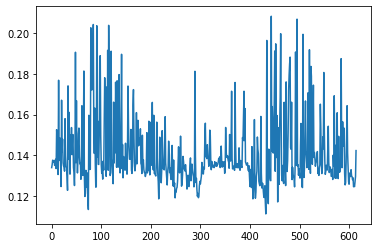

In [ ]:
# # now run model on test dataset
device = setup_device()
loss_fn = torch.nn.MSELoss()

model.eval()
y_pre_pred = model(x_test_tensor)
test_loss = loss_fn(y_pre_pred, y_test_tensor)
print("Test Loss: %1.5f" % (test_loss.item()))
LSTM_pre_pred = y_pre_pred.detach().numpy()
# print(LSTM_pre_pred)
print(y_test.shape)

import matplotlib.pyplot as plt
plt.plot(LSTM_pre_pred)
plt.show()

In [ ]:
# Comparision on test data
from google.colab import files
uploaded = files.upload()

Saving VSM1_daily_test_lstm.csv to VSM1_daily_test_lstm.csv


(MSE: TEM)：0.0019939564236204042
(MSE: LSTM)：0.0012258177161508716
(MSE: PGML)：0.0015669343355532936


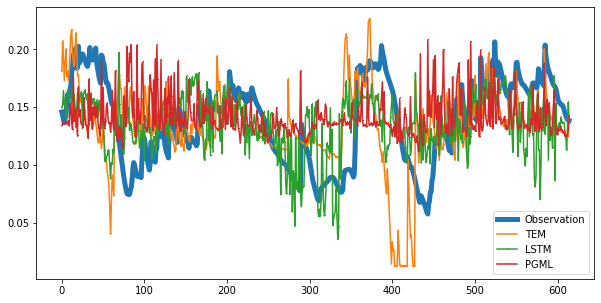

In [ ]:
# read test data set
TEM = pd.read_csv(io.BytesIO(uploaded['VSM1_daily_test_lstm.csv']), header=None)
TEM = TEM / 100
TEM_ori = TEM.iloc[:, 0]
TEM_opt = TEM.iloc[:, 2]
LSTM_ori = TEM.iloc[:, 3]
LSTM_pre_pred = y_pre_pred.detach().numpy()
x = np.arange(0,615,1)

# MSE
from sklearn.metrics import mean_squared_error, r2_score
print(f"(MSE: TEM)：{mean_squared_error(TEM_opt, y_test)}")
print(f"(MSE: LSTM)：{mean_squared_error(LSTM_ori, y_test)}")
print(f"(MSE: PGML)：{mean_squared_error(LSTM_pre_pred, y_test)}")

# plot figure
import matplotlib.pyplot as plt
Fig_comp = plt.figure(figsize=(10,5))
plt.plot(x, y_test, label="Observation", linestyle = "-", marker = ",", linewidth=5)
plt.plot(x, TEM_opt, label="TEM", linestyle = "-", marker = ",")
plt.plot(x, LSTM_ori, label="LSTM", linestyle = "-", marker = ",")
plt.plot(x, LSTM_pre_pred, label="PGML", linestyle = "-", marker = ",")
plt.legend()
plt.show()
Fig_comp.savefig('Comp_final.png')